# Graph Representations of OpenCL programs

In [1]:
# Preamble.
import collections
import contextlib
import multiprocessing
import pathlib
import typing
import time
import random

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from matplotlib import pyplot as plt

import humanize

import networkx as nx
import numpy as np
import pandas as pd
import tensorflow as tf
from absl import flags
from absl import logging
from graph_nets.demos import models as gn_models

from datasets.opencl.device_mapping import opencl_device_mapping_dataset
from deeplearning.clgen.corpuses import atomizers
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import base
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import ncc
from deeplearning.ncc import task_utils as inst2vec_utils
from deeplearning.ncc import vocabulary as inst2vec_vocabulary
from experimental.compilers.reachability import llvm_util
from deeplearning.deeptune.opencl.heterogeneous_mapping import heterogeneous_mapping
from deeplearning.deeptune.opencl.heterogeneous_mapping import utils
from deeplearning.deeptune.opencl.heterogeneous_mapping.models import models
from labm8 import logutil
from labm8 import prof
from labm8 import viz

flags.FLAGS(['argv[0]'])

%matplotlib inline

/home/cec/.cache/bazel/_bazel_cec/d1665aef25bbeeb91c01df7ddc90dba7/execroot/phd/bazel-out/k8-opt/bin/docs/wip_graph/notebooks/notebooks.runfiles/pypi__h5py_2_7_1/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with prof.ProfileToStdout('read dataset'):
    dataset = opencl_device_mapping_dataset.OpenClDeviceMappingsDataset()
    df = utils.AddClassificationTargetToDataFrame(dataset.df, 'amd_tahiti_7970')
df

read dataset in 0.194 seconds (started now)


,program:benchmark_suite_name,program:benchmark_name,program:opencl_kernel_name,program:opencl_src,data:dataset_name,param:amd_tahiti_7970:wgsize,param:nvidia_gtx_960:wgsize,feature:mem,feature:comp,feature:localmem,...,feature:atomic,feature:rational,feature:amd_tahiti_7970:transfer,feature:nvidia_gtx_960:transfer,runtime:intel_core_i7_3820,runtime:amd_tahiti_7970,runtime:nvidia_gtx_960,target_gpu_name,y,y_1hot
0,amd-app-sdk-3.0,BinomialOption,binomial_options,"__kernel void A(int a, const __global float4* ...",default,255,255,13,98,11,...,0,8,2048,2048,3.291073,1.443983,0.152038,amd_tahiti_7970,1,"[0, 1]"
1,amd-app-sdk-3.0,BitonicSort,bitonicSort,"__kernel void A(__global uint* a, const uint b...",default,256,256,6,12,0,...,0,2,131072,131072,0.121940,0.279521,0.057834,amd_tahiti_7970,0,"[1, 0]"
2,amd-app-sdk-3.0,BlackScholes,blackScholes,"__kernel void A(const __global float4* a, int ...",default,256,256,3,220,0,...,0,4,3145728,3145728,6.076052,2.740855,1.997728,amd_tahiti_7970,1,"[0, 1]"
3,amd-app-sdk-3.0,FastWalshTransform,fastWalshTransform,"__kernel void A(__global float* a, __const int...",default,256,256,4,8,0,...,0,0,4096,4096,0.130003,0.668892,0.062024,amd_tahiti_7970,0,"[1, 0]"
4,amd-app-sdk-3.0,FloydWarshall,floydWarshallPass,"__kernel void A(__global uint* a, __global uin...",default,256,256,5,11,0,...,0,1,524288,524288,0.283447,0.769755,0.604686,amd_tahiti_7970,0,"[1, 0]"
5,amd-app-sdk-3.0,MatrixMultiplication,mmmKernel,"__kernel void A(__global float4* a, __global f...",default,64,64,12,163,0,...,0,1,49152,49152,0.277644,1.120132,0.124211,amd_tahiti_7970,0,"[1, 0]"
6,amd-app-sdk-3.0,MatrixTranspose,matrixTranspose,"__kernel void A(__global float4* a, __global f...",default,256,256,16,42,8,...,0,0,32768,32768,0.156639,1.009519,0.087846,amd_tahiti_7970,0,"[1, 0]"
7,amd-app-sdk-3.0,PrefixSum,group_prefixSum,"__kernel void A(__global float* a, __global fl...",default,640,1024,12,36,8,...,0,10,4096,4096,0.484234,0.847908,0.049376,amd_tahiti_7970,0,"[1, 0]"
8,amd-app-sdk-3.0,Reduction,reduce,"__kernel void A(__global uint4* a, __global ui...",default,256,256,7,6,4,...,0,3,8208,8208,0.161025,0.887437,0.070912,amd_tahiti_7970,0,"[1, 0]"
9,amd-app-sdk-3.0,ScanLargeArrays,ScanLargeArrays,"__kernel void A(__global float* a, __global fl...",default,128,128,21,32,14,...,0,3,263168,263168,0.336185,0.793181,0.038630,amd_tahiti_7970,0,"[1, 0]"


In [3]:
model = models.Lda()
model.init(seed=0, atomizer=None)
model

In [4]:
with prof.ProfileToStdout('extracted graphs'):
    extracted_graphs = list(model.ExtractGraphs(df))

extracted graphs in 24.399 seconds (started 24 seconds ago)


In [5]:
with prof.ProfileToStdout('encoded graphs'):
    encoded_graphs = list(model.EncodeGraphs(extracted_graphs))

encoded graphs in 332.893 seconds (started 5 minutes ago)


In [6]:
unknowns = np.array([g.graph['num_unknown_statements'] / g.number_of_nodes() for _, g in encoded_graphs])
print(f'{unknowns.mean():.1%} of statements are unknown (min={unknowns.min():.1%}, max={unknowns.max():.1%})')

31.9% of statements are unknown (min=8.7%, max=92.1%)


In [7]:
with prof.ProfileToStdout('input target graphs'):
    input_target_graphs = list(model.GraphsToInputTargets(encoded_graphs))
    input_graphs, target_graphs = zip(*input_target_graphs)

input target graphs in 15.822 seconds (started 15 seconds ago)


## Save results to file

In [8]:
# Sanity check
assert len(input_graphs) == len(target_graphs) == len(encoded_graphs) == len(df)

# Add the graph representations to the dataframe they were extracted from.
df['lda:graph'] = [x[1] for x in encoded_graphs]
df['lda:input_graph'] = input_graphs
df['lda:target_graph'] = target_graphs

In [9]:
DF_PATH = pathlib.Path('/var/phd/shared/docs/wip_graph/lda_opencl_device_mapping_dataset_missing_features.pkl')

In [10]:
DF_PATH.parent.mkdir(exist_ok=True, parents=True)
pd.to_pickle(df, DF_PATH)

!ls -lh {DF_PATH}

-rw-rw-r-- 1 cec cec 722M Jan 24 21:58 /var/phd/shared/docs/wip_graph/lda_opencl_device_mapping_dataset_missing_features.pkl


## Analyze results

### Number of nodes in FFGs

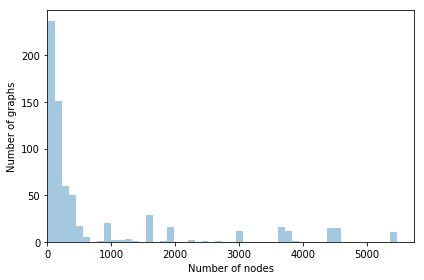

In [32]:
sns.distplot([g.number_of_nodes() for g in df['lda:graph']], kde=False)
plt.xlabel('Number of nodes')
plt.ylabel('Number of graphs')
plt.xlim((0, None))
viz.finalise()

### Number of edges in FFGs

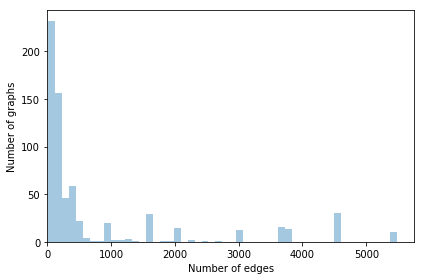

In [31]:
sns.distplot([g.number_of_edges() for g in df['lda:graph']], kde=False)
plt.xlabel('Number of edges')
plt.ylabel('Number of graphs')
plt.xlim((0, None))
viz.finalise()

### Draw graph shapes

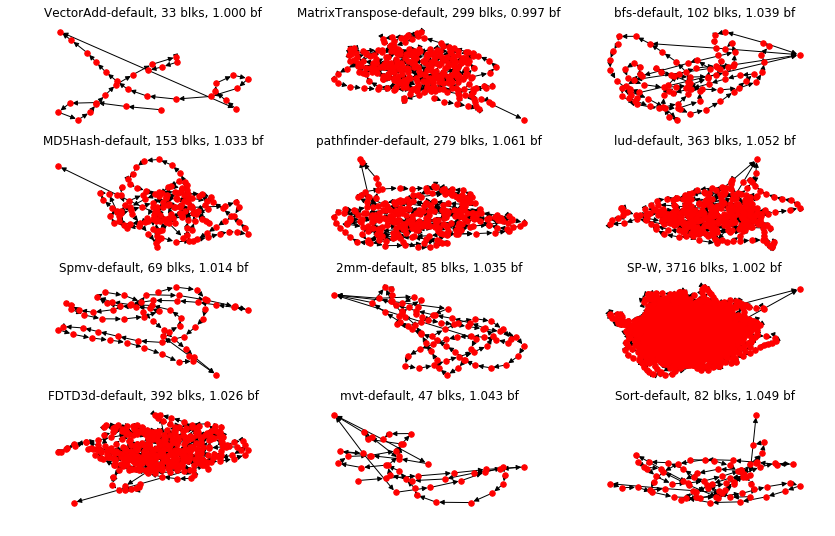

In [68]:
num_plots = (4, 3)

# Random state used to select graphs to draw, and controlling layout of graphs.
seed = 0xCEC

fig = plt.figure(figsize=(int(3.5 * num_plots[0]), int(3.2 * num_plots[1])))
fig.clf()

benchmarks = list(set(df['program:benchmark_name']))

rand = np.random.RandomState(seed=seed)
rand.shuffle(benchmarks)

for j in range(num_plots[0]):
    for i in range(num_plots[1]):
        ax_index = ((j * num_plots[1]) + i) + 1
        ax = fig.add_subplot(*num_plots, ax_index)
        benchmark_name = benchmarks[ax_index - 1]
        df_rows = df[df['program:benchmark_name'] == benchmark_name]
        df_row = rand.choice(df_rows.index)
        graph = df['lda:graph'][df_row]
        
        nx.draw_spring(graph, with_labels=False, node_size=30, ax=ax, random_state=rand)
        graph_name = '-'.join([df['program:benchmark_name'][df_row],
                               df['data:dataset_name'][df_row]])
        
        branch_factor = graph.number_of_edges() / graph.number_of_nodes()
        ax.set_title(f'{graph_name}, {graph.number_of_nodes()} blks, {branch_factor:.3f} bf',)

viz.finalise(tight=False)